# Агент для генерации LeanCanvas

## Введение

Этот ноутбук демонстрирует создание интеллектуального агента для автоматической генерации **Lean Canvas** — популярного инструмента для описания бизнес-модели стартапов. Lean Canvas помогает структурированно описать ключевые аспекты бизнеса: проблему, решение, целевую аудиторию, каналы привлечения клиентов и другие важные элементы.

Данный пример является дополнением к статье ["Ра­зра­бот­ка и при­ме­не­ние муль­ти­а­гент­ных сис­тем в кор­по­ра­тив­ной сре­де"](https://giga.chat/help/articles/multi-agent-system)

### Решаемая задача
Агент автоматизирует процесс создания Lean Canvas на основе краткого описания бизнес-идеи. Вместо ручного заполнения 9 блоков таблицы, пользователь просто описывает свою идею, а агент:
- Анализирует конкурентов через поиск в интернете
- Генерирует уникальные предложения
- Заполняет все разделы Lean Canvas
- Позволяет пользователю корректировать результат

### Демонстрируемые принципы LangGraph

В этом ноутбуке показаны ключевые концепции работы с **LangGraph**:

1. **ReAct агенты** — агенты, которые могут рассуждать (Reasoning) и действовать (Acting), используя внешние инструменты (поиск в интернете)

2. **Structured Output** — получение структурированных ответов от LLM в виде Pydantic моделей вместо произвольного текста

3. **State Graphs** — создание сложных workflow с состоянием, где каждый узел выполняет определенную задачу и обновляет глобальное состояние

4. **Human in the Loop** — интеграция человека в процесс работы агента для предоставления обратной связи и корректировок

5. **Interrupt & Resume** — механизм прерывания выполнения графа для получения пользовательского ввода и последующего возобновления работы

6. **Conditional Routing** — динамическое определение следующего шага на основе результатов анализа (например, переход к генерации нового предложения, если текущее не уникально)

7. **Memory & Checkpoints** — сохранение состояния между вызовами для возможности продолжения работы

Этот пример показывает, как можно создавать сложные многошаговые агенты, которые сочетают автоматизацию с возможностью человеческого контроля и корректировки.

# Настраиваем окружение

Установка зависимостей

In [ ]:
!pip install langchain_gigachat  langgraph ddgs langchain_tavily -q


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Настройка переменных окружения

Для корректной работы примера в переменных окружения должны быть указаны параметры для подключения к GigaChat API. Подробно о том, как создать проект GigaChat API — в официальной документации, в разделах [Быстрый старт для физических лиц](https://developers.sber.ru/docs/ru/gigachat/individuals-quickstar) и [Быстрый старт для ИП и юридических лиц](https://developers.sber.ru/docs/ru/gigachat/legal-quickstart).

### Шаги настройки:

1. **Переименуйте файл `.env.example` в `.env`**
2. **Заполните файл `.env` необходимыми данными:**
    - Данные для подключения к GigaChat API
    - API ключ для Tavily (для поиска в интернете)

Подробная инструкция по настройке переменных окружения доступна в [официальном репозитории GigaChat](https://github.com/ai-forever/gigachat?tab=readme-ov-file#%D0%BD%D0%B0%D1%81%D1%82%D1%80%D0%BE%D0%B9%D0%BA%D0%B0-%D0%BF%D0%B5%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85-%D0%BE%D0%BA%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F).

In [1]:
from rich import print
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

## Подключаем GigaChat и проверяем его работу

In [2]:
from langchain_gigachat import GigaChat

llm = GigaChat(model="GigaChat-2-Max", 
    profanity_check=False,
    top_p=0,
    timeout=120
)
print(llm.invoke("Кто тебя сделал?").content)

Меня создала компания Sber в России в 2023 году.

## Создаем ReAct агента с возможностью поиска в интернете

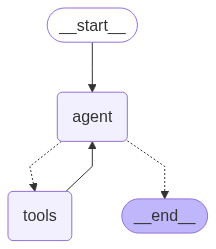

In [6]:
from langgraph.prebuilt import create_react_agent
from ddgs import DDGS
from langchain.tools import tool

@tool("search_tool", description="Ищет в поисковике (RU, неделя, 5 ссылок)")
def search_tool(query: str, max_results: int = 5) -> str:
    with DDGS() as ddgs:
        hits = ddgs.text(query, region="ru-ru", time="w", max_results=max_results)
        return "\n".join(f"{hit['title']}: {hit['body']} -- {hit['href']}" for hit in hits[:max_results])


agent = create_react_agent(llm, tools=[search_tool], prompt="Ты полезный ассистент")
agent

In [7]:
inputs = {"messages": [("user", "Какая самая дорогая компания в мире на сегодня?")]}
messages = agent.invoke(inputs)['messages']

In [8]:
print(messages[-1].content)

На сегодняшний день самой дорогой компанией в мире является **NVIDIA**, которая в 2024 году впервые в истории 
достигла капитализации более $4 триллионов. Однако стоит учитывать, что рыночные оценки могут изменяться ежедневно 
из-за колебаний акций.

Ранее лидерами были:

- **Microsoft** ($2,859 трлн)
- **Apple**

Эти компании также остаются одними из крупнейших по стоимости капитала. Для получения актуальной информации 
рекомендуется проверять последние новости или специализированные ресурсы, такие как Bloomberg, Yahoo Finance или 
Google Finance.

## Изучим лог работы агента
Видно, что агент сначала сделал вызов функции, затем LLM обработала результат поиска и потом подготовила итоговый ответ для пользователя.

In [9]:
print(messages)

[
    HumanMessage(
        content='Какая самая дорогая компания в мире на сегодня?',
        additional_kwargs={},
        response_metadata={},
        id='bc97ab55-f7d4-4b19-8170-0b03ba14075b'
    ),
    AIMessage(
        content='',
        additional_kwargs={
            'function_call': {
                'name': 'search_tool',
                'arguments': {'query': 'самая дорогая компания в мире на сегодня'}
            },
            'functions_state_id': '15dac049-56d3-4f0d-a19d-730d85420f5f'
        },
        response_metadata={
            'token_usage': {
                'prompt_tokens': 86,
                'completion_tokens': 31,
                'total_tokens': 117,
                'precached_prompt_tokens': 2
            },
            'model_name': 'GigaChat-2-Max:2.0.28.2',
            'x_headers': {
                'x-request-id': '286ad213-25f8-4a93-9c84-6e134adfd262',
                'x-session-id': '6a0c736e-4015-4dc8-8b76-199ca8a19867',
                'x-client-id': None
            },
            'finish_reason': 'function_call'
        },
        id='286ad213-25f8-4a93-9c84-6e134adfd262',
        tool_calls=[
            {
                'name': 'search_tool',
                'args': {'query': 'самая дорогая компания в мире на сегодня'},
                'id': '37588585-135e-4dd5-a798-d32890695398',
                'type': 'tool_call'
            }
        ],
        usage_metadata={
            'output_tokens': 31,
            'input_tokens': 86,
            'total_tokens': 117,
            'input_token_details': {'cache_read': 2}
        }
    ),
    ToolMessage(
        content='ТОП самых дорогих в мире компаний — Reuters: Jan 13, 2024 · Рыночная оценка Microsoft достигла 
$2,859 трлн после того, как акции компании закрылись на 0,5% выше. В течение сессии они выросли на целых 2%, и 
компания кратковременно стоила $2,903 трлн. -- 
https://psm7.com/ru/news/top-samyx-dorogix-v-mire-kompanij-reuters.html\nСамая дорогая компания в мире по версии 
Forbes в 2025 году: Apple — самая дорогая компания в мире в 2025 году Технический гигант Apple в 2025 году 
по-прежнему обходит Amazon и сохраняет звание самой дорогой и богатой в мире компании. -- 
https://bizneslab.com/reyting-samyh-dorogih-kompaniy-v-mire/\nСамые дорогие компании в мире - Astons: Nov 29, 2023 
· Топ 10 дорогих компаний в мире по рыночной капитализации. Статистика на середину ноября. Получите актуальные 
данные на нашем сайте. -- https://www.astons.com/ru/news/samye-dorogie-kompanii-v-mire/\nСамые дорогии компании в 
мире - топ-20 дорогих компаний: Aug 13, 2025 · Собрали самые дорогие компании по рыночной капитализации. Не 
забывайте, что этот список постоянно обновляется – данные актуальны на декабрь 2024. -- 
https://shop.renlife.ru/articles/samye-dorogie-kompanii-mira-top-20\nСамые дорогие компании в мире — ТОП-10 по 
капитализации: Jul 18, 2025 · Только в 2024 году выручка компании выросла почти в 2,5 раза, а сама Nvidia обогнала 
всех и стала первой в истории компанией с капитализацией свыше $4 трлн. -- 
https://postium.ru/samye-dorogie-kompanii-v-mire/',
        name='search_tool',
        id='66e8e8ff-c8e4-42ec-a292-76386bf47c6e',
        tool_call_id='37588585-135e-4dd5-a798-d32890695398'
    ),
    AIMessage(
        content='На сегодняшний день самой дорогой компанией в мире является **NVIDIA**, которая в 2024 году 
впервые в истории достигла капитализации более $4 триллионов. Однако стоит учитывать, что рыночные оценки могут 
изменяться ежедневно из-за колебаний акций.\n\nРанее лидерами были:\n\n- **Microsoft** ($2,859 трлн)\n- 
**Apple**\n\nЭти компании также остаются одними из крупнейших по стоимости капитала. Для получения актуальной 
информации рекомендуется проверять последние новости или специализированные ресурсы, такие как Bloomberg, Yahoo 
Finance или Google Finance.',
        additional_kwargs={'functions_state_id': 'db37cfbf-ceed-42cf-a13e-2628a7f8f764'},
        response_metadata={
            'token_usage': {
        

# LeanCanvas
Мы создадим пример заполнения таблицы Lean Canvas. Подробнее про этот подход можно прочитать на [Хабре](https://habr.com/ru/companies/productstar/articles/508994/)

## Structured output - наивный подход

In [16]:
from pydantic import BaseModel

class LeanCanvasResult(BaseModel):
    """
    Представляет результат генерации Lean Canvas.
    Каждое поле соответствует разделу Lean Canvas.
    """
    problem: str  # Проблема, которую пытается решить продукт или услуга.
    solution: str  # Краткое описание предлагаемого решения.
    key_metrics: str  # Ключевые показатели, которые необходимо измерять для отслеживания прогресса.
    unique_value_proposition: str  # Единое, ясное и убедительное сообщение, объясняющее, почему вы отличаетесь от других и почему стоит покупать именно у вас.
    unfair_advantage: str  # То, что конкуренты не могут легко скопировать или купить.
    channels: str  # Пути охвата ваших клиентских сегментов.
    customer_segments: str  # Целевая аудитория или группы людей, которых вы пытаетесь охватить.
    cost_structure: str  # Основные затраты, связанные с ведением бизнеса.
    revenue_streams: str  # Как бизнес будет зарабатывать деньги.

Выше мы создали **Pydantic модель** - это демонстрация технологии **Structured Output**.

**Что это дает:**
- Вместо произвольного текста LLM возвращает данные в строго определенном формате
- Автоматическая валидация ответов
- Возможность программно работать с результатами

In [17]:
structured_llm = llm.with_structured_output(LeanCanvasResult)

prompt = "Создайте Lean Canvas для онлайн-платформы изучения языков, которая связывает изучающих язык с носителями языка."

print(structured_llm.invoke(prompt))

LeanCanvasResult(
    problem='Трудности в изучении языка, нехватка практики общения с носителями языка, отсутствие мотивации и 
дисциплины, высокие цены на языковые курсы, нехватка времени на посещение традиционных языковых школ.  ",\n    ',
    solution='Онлайн-платформа, связывающая изучающих язык с носителями языка для практики общения, доступ к 
учебным материалам и курсам, возможность выбора удобного времени и формата занятий, мотивационные программы и 
достижения.  ",\n    ',
    key_metrics='Количество активных пользователей, количество проведенных уроков, коэффициент удержания 
пользователей, средняя продолжительность урока, количество рефералов, доход на одного пользователя.  ",\n    ',
    unique_value_proposition='Изучение языка с носителями в удобное время и по доступной цене, возможность выбора 
формата занятий и учебных материалов, мотивационные программы и достижения, персонализированные рекомендации по 
обучению.  "\n}',
    unfair_advantage='Уникальная система подбора преподавателей и учеников на основе интересов и целей, 
персонализированные рекомендации по обучению, возможность выбора удобного времени и формата занятий, доступ к 
эксклюзивным учебным материалам и курсам.  ",\n    ',
    channels='Платформы социальных сетей, реферальные программы, контент-маркетинг, SEO, партнерские программы с 
языковыми школами и университетами.  ",\n    ',
    customer_segments='Изучающие иностранные языки, студенты, путешественники, эмигранты, корпоративные клиенты, 
преподаватели и репетиторы.  ",\n    ',
    cost_structure='Разработка и поддержка платформы, маркетинг и привлечение пользователей, оплата труда 
модераторов и администраторов, юридические и бухгалтерские расходы.  ",\n    ',
    revenue_streams='Подписка на платформу, комиссия с каждого урока, продажа дополнительных материалов и курсов, 
реклама и спонсорство, корпоративные контракты.  ",\n    '
)

Выше мы увидели как работает принудительное структурирование ответа:
- LLM получил свободный запрос про языковую платформу
- Но **обязательно** ответил в формате нашей Pydantic модели
- Все 9 полей Lean Canvas заполнились автоматически

Теперь  реализуем этот подход в рамках агента.

## Агентный подход

### Стейт графа
Глобальное пространство данных в котором идет работа с графом

Используем такой же структурированный подход, но будем получать не сразу заполненный Lean Canvas, а поэтапно, перемещаясь по графу. При этом у нас заранее будет задана структура данных, которая заполнится, когда будут пройдены шаги от начала графа и до конца. 

In [ ]:
from langgraph.graph import END, START, StateGraph
from typing_extensions import TypedDict, Annotated

class LeanGraphState(TypedDict):
    main_task: Annotated[str, "Основная задача от пользователя"]
    competitors_analysis: Optional[Annotated[str, "Анализ конкурентов"]]
    feedback: Optional[
        Annotated[
            str, "Фидбек от пользователя. Обязательно учитывай его в своих ответах!"
        ]
    ]

    # Lean Canvas
    problem: Optional[
        Annotated[str, "Проблема, которую пытается решить продукт или услуга."]
    ]
    solution: Optional[Annotated[str, "Краткое описание предлагаемого решения."]]
    key_metrics: Optional[
        Annotated[
            str,
            "Ключевые показатели, которые необходимо измерять для отслеживания прогресса.",
        ]
    ]
    unique_value_proposition: Optional[
        Annotated[
            str,
            "Единое, ясное и убедительное сообщение, объясняющее, почему вы отличаетесь от других и почему стоит покупать именно у вас.",
        ]
    ]
    unfair_advantage: Optional[
        Annotated[str, "То, что конкуренты не могут легко скопировать или купить."]
    ]
    channels: Optional[Annotated[str, "Пути охвата ваших клиентских сегментов."]]
    customer_segments: Optional[
        Annotated[
            str, "Целевая аудитория или группы людей, которых вы пытаетесь охватить."
        ]
    ]
    cost_structure: Optional[
        Annotated[str, "Основные затраты, связанные с ведением бизнеса."]
    ]
    revenue_streams: Optional[Annotated[str, "Как бизнес будет зарабатывать деньги."]]


def state_to_string(state: LeanGraphState) -> str:
    """
    Преобразует состояние в строку для отображения.
    """
    result = []
    for field, annotation in LeanGraphState.__annotations__.items():
        value = state.get(field, "")
        if value:
            # annotation is typing.Annotated[type, description]
            if hasattr(annotation, "__metadata__") and annotation.__metadata__:
                desc = annotation.__metadata__[0]
            else:
                desc = ""
            result.append(f"{desc} ({field}): {value}")
    return "\n".join(result)


### Основные шаги генерации
Ниже представлены функция-обертка для обращения к LLM и функции узлов заполнения Lean Canvas.

In [19]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from langgraph.types import interrupt
from langchain_core.runnables.config import RunnableConfig

def ask_llm(state: LeanGraphState, question: str, config: RunnableConfig) -> str:
    TEMPLATE = """
    Ты - эксперт в области стартапов и Lean Canvas. Твоя задача - помочь пользователю создать Lean Canvas для его задачи.
    Учитывай уже заполненные части таблицы Lean Canvas и главную задачу пользователя (main_task).
    
    Обязательно учитывай фидбек от пользователя (feedback), если он задан.
    <STATE>
    {state}
    </STATE>
    
    Ответь на вопрос: {question}
    Отвечай коротко, не более 1-2 коротких предложений и обязательно учти фидбек от пользователя (feedback), если он задан. Оформи ответ в виде буллетов.
    """
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", TEMPLATE)
    ])
    
    model  = config["configurable"].get("model", "GigaChat-2-Max")
    chain = prompt | llm.bind(model=model) | StrOutputParser()
    return chain.invoke({"state": state_to_string(state), "question": question})

def customer_segments(state: LeanGraphState, config: RunnableConfig):
    return {"customer_segments": ask_llm(state, "Кто ваши целевые клиенты?", config)}

def problem(state: LeanGraphState, config: RunnableConfig):
    return {"problem": ask_llm(state, "Какую проблему вы решаете?", config)}

def unique_value_proposition(state: LeanGraphState, config: RunnableConfig):
    return {"unique_value_proposition": ask_llm(state, "Какое уникальное предложение вы предлагаете?", config)}

def solution(state: LeanGraphState, config: RunnableConfig):
    return {"solution": ask_llm(state, "Какое решение вы предлагаете для этой проблемы?", config)}

def channels(state: LeanGraphState, config: RunnableConfig):
    return {"channels": ask_llm(state, "Какие каналы привлечения клиентов вы используете?", config)}

def revenue_streams(state: LeanGraphState, config: RunnableConfig):
    return {"revenue_streams": ask_llm(state, "Как вы планируете зарабатывать деньги?", config)}

def cost_structure(state: LeanGraphState, config: RunnableConfig):
    return {"cost_structure": ask_llm(state, "Какова структура ваших затрат?", config)}

def key_metrics(state: LeanGraphState, config: RunnableConfig):
    return {"key_metrics": ask_llm(state, "Какие ключевые показатели вы будете отслеживать?", config)}

def unfair_advantage(state: LeanGraphState, config: RunnableConfig):
    return {"unfair_advantage": ask_llm(state, "Какое ваше конкурентное преимущество?", config)}

### Агент (роль) проверки уникальности идеи
- Использует интернет для формирования действительно уникальных предложений
- Принимает решение - нужно ли генерировать новые идеи или можно продолжать генерацию
- Демонстрирует принцип handoff с помощью Command

In [24]:
from typing_extensions import Literal
from langgraph.types import Command
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_tavily import TavilySearch

class CompetitorsAnalysisResult(BaseModel):
    """Анализ конкурентов"""
    thoughts: str = Field(description="Мысли по поводу ответа")
    solution: str = Field(description="Какие конкуренты существуют и чем они отличаются от вашего продукта")
    is_unique: bool = Field(description="Уникально ли ваше предложение?")

COMPETITION_ANALYSIS_TEMPLATE = """Ты работаешь над таблицей Lean Canvas и тебе нужно проанализировать конкурентов.

Учитывай уже заполненные части таблицы Lean Canvas и главную задачу пользователя (main_task).
<STATE>
{state}
</STATE>

Результаты поиска по запросу "{unique_value_proposition}". Учитывай их, чтобы понять, уникальную ли идею ты придумал.
Если в поиске нет ничего похожего, значит идея вероятно уникальная.
<SEARCH_RESULTS>
{search_results}
</SEARCH_RESULTS>

Выведи только следующую информацию в формате JSON:
{format_instructions}"""

def check_unique(state: LeanGraphState, config: RunnableConfig) -> Command[Literal["4_solution", "3_unique_value_proposition"]]:
    if config["configurable"].get("skip_search", False):
        # Если пропускаем поиск, то просто переходим к следующему шагу
        return Command(goto="4_solution")
    
    parser = PydanticOutputParser(pydantic_object=CompetitorsAnalysisResult)
    prompt = ChatPromptTemplate.from_messages([
        ("system", COMPETITION_ANALYSIS_TEMPLATE)
    ]).partial(format_instructions=parser.get_format_instructions())
    
    search_results_text = TavilySearch().run(state["unique_value_proposition"])    
    
    chain = prompt | llm | parser
    res = chain.invoke(
        {
            "state": state_to_string(state),
            "unique_value_proposition": state["unique_value_proposition"],
            "search_results": search_results_text
        }
    )
    
    competitors_analysis = state.get("competitors_analysis", "") + "\n" + state["unique_value_proposition"] + " - " + res.solution
    
    if res.is_unique:
        # Если предложение уникально, переходим к следующему шагу
        return Command(
            update={"competitors_analysis": competitors_analysis.strip()},
            goto="4_solution",
        )
    else:
        # Если предложение не уникально, возвращаемся к шагу "3_unique_value_proposition"
        return Command(
            update={"competitors_analysis": competitors_analysis.strip()},
            goto="3_unique_value_proposition",
        )


### Фидбек от пользователя

Агент обращается к пользователю с просьбой дать обратную связь по текущей генерации. Пользователь может дать фидбек и указать с какого узла графа следует начать повторную генерацию или он может сказать, что результат его устраивает, тогда будет выполнена финальная генерация структуры Lean Canvas.

Список принципов, которые продемонстрированы в данном разделе:
- Human in the loop
- Interrupt
- Handoff

In [ ]:
from typing import Literal, TypeAlias

RedirectStep: TypeAlias = Literal[
    "1_customer_segments",
    "2_problem",
    "3_unique_value_proposition",
    "4_solution",
    "5_channels",
    "6_revenue_streams",
    "7_cost_structure",
    "8_key_metrics",
    "9_unfair_advantage",
    "__end__"
]

class UserFeedback(BaseModel):
    """Анализ конкурентов"""
    feedback: str = Field(description="Фидебек пользователя, что надо исправить")
    next_step: RedirectStep = Field(description="Следующий шаг в Lean Canvas")
    is_done: bool = Field(description="Можно ли завершать создание Lean Canvas?")
    
FEEDBACK_TEMPLATE = """Ты работаешь над таблицей Lean Canvas. Ты уже сгенерировал версию Lean Canvas и получил фидбек от пользователя.
Тебе нужно разобраться фидбек и понять, как действовать дальше, заполнив таблицу с ответом.

Учитывай уже заполненные части таблицы Lean Canvas и главную задачу пользователя (main_task).
<STATE>
{state}
</STATE>

Вот фидбек пользователя на твою работу:
{feedback}

Извлеки из него данные для дальнейшей работы. Если пользователь всем доволен или не говорит ничего конкретного, 
то прими решение закончить генерацию (is_done = True).
Выведи только следующую информацию в формате JSON:
{format_instructions}"""

def get_feedback(
    state: LeanGraphState, config: RunnableConfig
) -> Command[Literal[RedirectStep, END]]:
    if config["configurable"].get("need_interrupt"):
        feedback = interrupt("""Пожалуйста, дайте обратную связь по Lean Canvas. Если все хорошо, напишите 'Хорошо'. 
    Если нужно что-то изменить, напишите, что именно и с какого шага начать.""")
    else:
        feedback = "Все хорошо!"

    parser = PydanticOutputParser(pydantic_object=UserFeedback)
    prompt = ChatPromptTemplate.from_messages([
        ("system", FEEDBACK_TEMPLATE)
    ]).partial(format_instructions=parser.get_format_instructions())
    
  
    chain = prompt | llm | parser
    res = chain.invoke(
        {
            "state": state_to_string(state),
            "feedback": feedback,
        }
    )
    
    if res.is_done:
        return Command(update={}, goto=END)
    else:
        # Если предложение не уникально, возвращаемся к шагу "3_unique_value_proposition"
        return Command(
            update={"feedback": res.feedback},
            goto=res.next_step,
        )


# Сборка графа
Соберем узлы графа в правильную последовательность действий, добавим чек-пойнт для сохранения состояний и преобразуем в исполняемого агента (компиляция графа).

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

class GraphConfig(BaseModel):
    need_interrupt: bool = True


graph = StateGraph(LeanGraphState, config_schema=GraphConfig)

graph.add_node("1_customer_segments", customer_segments)
graph.add_node("2_problem", problem)
graph.add_node("3_unique_value_proposition", unique_value_proposition)
graph.add_node("3.1_check_unique", check_unique)
graph.add_node("4_solution", solution)
graph.add_node("5_channels", channels)
graph.add_node("6_revenue_streams", revenue_streams)
graph.add_node("7_cost_structure", cost_structure)
graph.add_node("8_key_metrics", key_metrics)
graph.add_node("9_unfair_advantage", unfair_advantage)
graph.add_node("get_feedback", get_feedback)

graph.add_edge(START, "1_customer_segments")
graph.add_edge("1_customer_segments", "2_problem")
graph.add_edge("2_problem", "3_unique_value_proposition")
graph.add_edge("3_unique_value_proposition", "3.1_check_unique")
graph.add_edge("4_solution", "5_channels")
graph.add_edge("5_channels", "6_revenue_streams")
graph.add_edge("6_revenue_streams", "7_cost_structure")
graph.add_edge("7_cost_structure", "8_key_metrics")
graph.add_edge("8_key_metrics", "9_unfair_advantage")
graph.add_edge("9_unfair_advantage", "get_feedback")

memory = MemorySaver()
app = graph.compile(checkpointer=memory)

Визуализируем получившийся граф.
На этом этапе может понадобиться установка библиотеки pyppeteer. Он довольно большая, поэтому данный шаг можно пропустить.

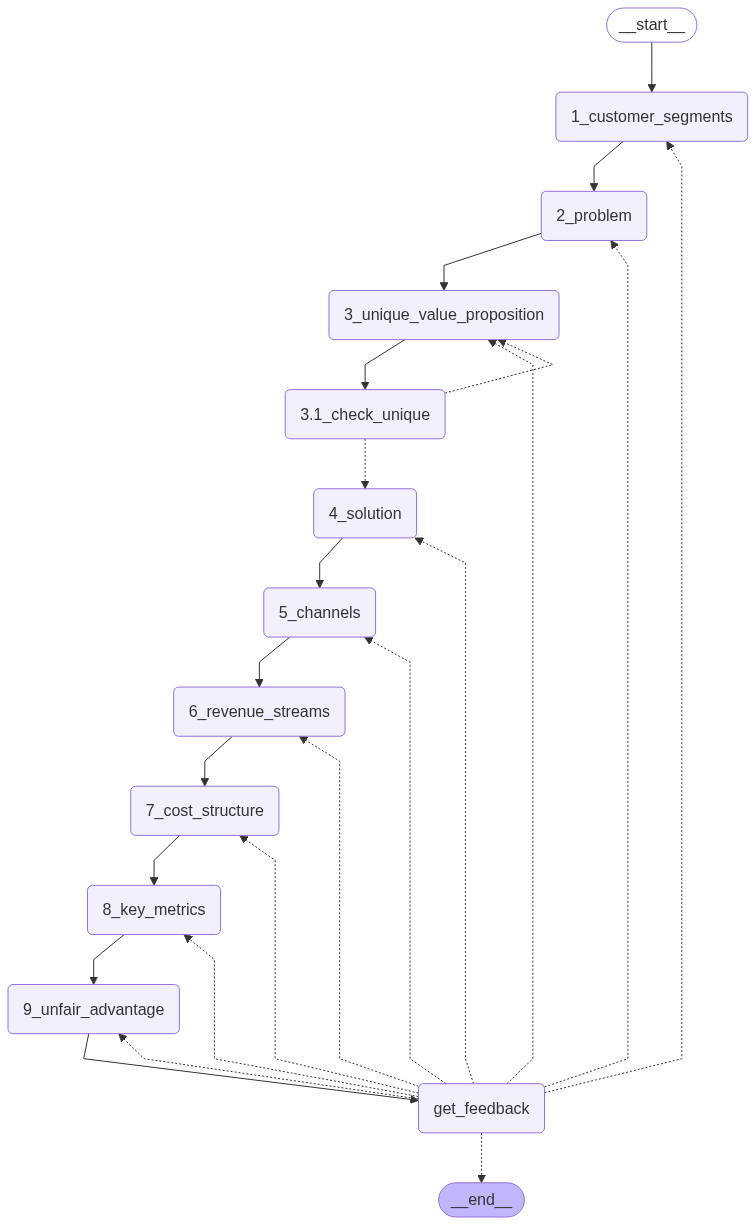

In [27]:
from utils import show_graph
show_graph(app)

Запустим выполнение приложения с помощью функции `execute_graph`.

In [28]:
def execute_graph(inputs, conf: RunnableConfig):
    """Выводит поток событий от агента. Обрабатывает прерывания (human in the loop)"""
    for event in app.stream(inputs, config=conf):
        print(event)
    
    while '__interrupt__' in event:
        print(f"Agent interrupted. {event['__interrupt__'][0].value}")
        user_input = input("User: ")
        print(f"User input: {user_input}")
        for event in app.stream(Command(resume=user_input), config=conf):
            print(event)

In [29]:
import uuid

inputs = {"main_task": "Онлайн платформа для изучения английского языка с AI-агентами"}
conf = {"configurable": {"thread_id": str(uuid.uuid4()),
                         "need_interrupt": True,
                         "skip_search": False,}}

execute_graph(inputs, conf)
        

{
    '1_customer_segments': {
        'customer_segments': '- Студенты и взрослые, желающие изучать английский язык онлайн  \n- Пользователи, 
предпочитающие интерактивное обучение через общение с искусственным интеллектом'
    }
}

{
    '2_problem': {
        'problem': '- Отсутствие эффективного и увлекательного способа изучения английского языка онлайн.\n- 
Сложность поддержания мотивации и вовлеченности во время самостоятельного обучения.'
    }
}

{
    '3_unique_value_proposition': {
        'unique_value_proposition': '- Уникальная онлайн-платформа для изучения английского языка с использованием 
AI-агентов, обеспечивающая эффективное, увлекательное и мотивирующее взаимодействие.'
    }
}

{
    '3.1_check_unique': {
        'competitors_analysis': '- Уникальная онлайн-платформа для изучения английского языка с использованием 
AI-агентов, обеспечивающая эффективное, увлекательное и мотивирующее взаимодействие. - Конкуренты включают:\n- 
Приложения и платформы, предлагающие практику разговорной речи и улучшение произношения.\n- Сервисы, 
предоставляющие интерактивные уроки и обратную связь от AI-агентов.\nОднако ни один из найденных сервисов не 
описывает себя как "уникальную платформу", специально акцентирующую внимание на эффективном, увлекательном и 
мотивирующем взаимодействии с AI-агентами, как указано в вашем предложении.'
    }
}

{
    '4_solution': {
        'solution': '- Онлайн-платформа для изучения английского языка с уникальными AI-агентами, обеспечивающими 
эффективное, увлекательное и мотивирующее взаимодействие.'
    }
}

{
    '5_channels': {
        'channels': '- Таргетированная реклама в социальных сетях  \n- SEO-продвижение и контент-маркетинг на 
тематических ресурсах  \n- Партнерство с образовательными платформами и языковой школами'
    }
}

{
    '6_revenue_streams': {
        'revenue_streams': '- Подписка на премиум-функциональность платформы  \n- Продажа дополнительного 
образовательного контента и курсов'
    }
}

{
    '7_cost_structure': {
        'cost_structure': '- Разработка и поддержка платформы  \n- Создание и обновление контента  \n- 
Маркетинговые расходы  \n- Заработная плата сотрудников  \n- Инфраструктурные затраты (хостинг, облачные сервисы)'
    }
}

{
    '8_key_metrics': {
        'key_metrics': '- Уровень удержания пользователей (Retention Rate)  \n- Количество активных пользователей 
ежемесячно (MAU)  \n- Коэффициент конверсии бесплатных пользователей в платящих подписчиков  \n- Средняя 
продолжительность сессии и частота взаимодействия с AI-агентом  \n- Оценки удовлетворённости клиентов (NPS, CSAT)'
    }
}

{
    '9_unfair_advantage': {
        'unfair_advantage': '- Уникальное сочетание AI-агентов, обеспечивающих эффективное, увлекательное и 
мотивирующее изучение английского языка онлайн.  \n- Платформа ориентирована на поддержание высокой мотивации и 
вовлеченности пользователей благодаря персонализированному взаимодействию с виртуальными ассистентами.'
    }
}

{
    '__interrupt__': (
        Interrupt(
            value="Пожалуйста, дайте обратную связь по Lean Canvas. Если все хорошо, напишите 'Хорошо'. \n    Если 
нужно что-то изменить, напишите, что именно и с какого шага начать.",
            resumable=True,
            ns=['get_feedback:9067aee4-1ed1-f8cf-0473-5b78b44a9b50']
        ),
    )
}

Agent interrupted. Пожалуйста, дайте обратную связь по Lean Canvas. Если все хорошо, напишите 'Хорошо'. 
    Если нужно что-то изменить, напишите, что именно и с какого шага начать.

User input: Все хорошо

{'get_feedback': None}

# Вывод результата

In [18]:
from utils import show_lean_canvas

current_state_values = app.get_state(config=conf).values
state = LeanGraphState(**current_state_values)
# show_lean_canvas(state)

In [6]:
# show_lean_canvas(state)

![Lean Canvas](lean_canvas.png)

# Валидация

Теперь покажем, как можно проводить логирование и затем качественно и количественно оценивать результаты работы агента. В качестве платформы для логирования используем [Arize Phoenix](https://phoenix.arize.com/). Этот опенсорс инструмент легко использовать как локально, так и развернув на сервере. 

## Запуск Arize Phoenix

Arize phoenix - opensource решение для отладки и валидации LLM-приложений. Его можно запустить прямо в jupyter notebook. После запуска веб-интерфейс будет доступен по адресу http://localhost:6006/

In [ ]:
# !pip install arize-phoenix opentelemetry-exporter-otlp openinference-instrumentation-langchain pandas -U -q

In [7]:
import phoenix as px
session = px.launch_app(use_temp_dir=False)

/Users/knkrestnikov/Documents/giga/gigachain/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
💽 Your data is being persisted to sqlite:////Users/knkrestnikov/.phoenix/phoenix.db
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


### Загружаем датасет в Phoenix
В качестве валидационного датасета используем файл validation_data.txt. Преобразуем его в DataFrame и передадим в Phoenix.

In [18]:
with open('validation_data.txt', 'r') as f:
    questions = [line.strip() for line in f]

print(f"Total questions: {len(questions)}")

Total questions: 30

In [ ]:
import pandas as pd
import phoenix as px

dataset_df = pd.DataFrame(data={"question": questions})

px.launch_app()
client = px.Client()

dataset = client.upload_dataset(
    dataframe=dataset_df,
    dataset_name="lean_canvas_questions",
    input_keys=["question"],
)

Existing running Phoenix instance detected! Shutting it down and starting a new instance...
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/contextlib.py:148: SAWarning: Skipped unsupported reflection of expression-based index ix_cumulative_llm_token_count_total
  next(self.gen)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/contextlib.py:148: SAWarning: Skipped unsupported reflection of expression-based index ix_latency
  next(self.gen)


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix
📤 Uploading dataset...
💾 Examples uploaded: http://localhost:6006/datasets/RGF0YXNldDox/examples
🗄️ Dataset version ID: RGF0YXNldFZlcnNpb246MQ==


running experiment evaluations |██        | 6/30 (20.0%) | ⏳ 00:32<02:09 |  5.41s/it


![Dataset](dataset.png)

## Проводим эксперимент на GigaChat Lite

В качестве критерия оценки работы агента можно создать собственную функцию, которая по жесткому алгоритму будет выдавать оценку ответу. Например, зададим просто оценку по длине. Пусть просто оценивается, что длина ответа входит в диапазон от 400 до 3000 символов, а также все 9 полей присутствуют в виде корректного JSON.

In [32]:
from phoenix.experiments import evaluate_experiment, run_experiment
from phoenix.experiments.types import Example
import json

def create_experiment(name, model):
    def run_step(example: Example):
        inputs = {"main_task": example.input["question"]}
        conf = {"configurable": {"thread_id": str(uuid.uuid4()),
                                "model": model,
                                "need_interrupt": False,
                                "skip_search": True,}}
        resp = app.invoke(inputs, config=conf)
        resp.pop("main_task")
        return resp

    def check_structure(expected, output) -> bool:
        resp_st = json.dumps(output, ensure_ascii=False)
        if len(resp_st) > 3000 or len(resp_st) < 400:
            return False
        return True

    return run_experiment(
        client.get_dataset(name="lean_canvas_questions"),
        run_step,
        evaluators=[check_structure],
        experiment_name=name,
        experiment_description="",
    )

experiment = create_experiment("Lean Canvas GigaChat-Lite", "GigaChat-2")    

🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.


🧪 Experiment started.
📺 View dataset experiments: http://localhost:6006/datasets/RGF0YXNldDox/experiments
🔗 View this experiment: http://localhost:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDox


running tasks |██████████| 30/30 (100.0%) | ⏳ 03:43<00:00 |  7.45s/it
🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.


✅ Task runs completed.
🧠 Evaluation started.


running experiment evaluations |██████████| 30/30 (100.0%) | ⏳ 00:00<00:00 | 119.30it/s


🔗 View this experiment: http://localhost:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDox

Experiment Summary (05/22/25 11:00 PM +0300)
--------------------------------------------
         evaluator   n  n_scores  avg_score  n_labels  \
0  check_structure  30        30   0.033333        30   

               top_2_labels  
0  {'False': 29, 'True': 1}  

Tasks Summary (05/22/25 11:00 PM +0300)
---------------------------------------
   n_examples  n_runs  n_errors
0          30      30         0


## Валидация качества ответа - llm as judge

Часто оценка ответа не может быть оформлена в жесткий алгоритм, поэтому часто используют подход LLM as Judge.

Важно! Данный пример показан только для демонстрации того, как можно делать оценку с помощью LLM и содержит два допуска, которые не нужно повторять в реальной жизни:
- Оценка модели с помощью нее самой. Нужно использовать другую, желательно более мощную модель.
- Оценка по градиентной шкале. Желательно использовать бинарную оценку.

In [35]:
def check_output_quality(output) -> float:
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Оцени качество заполнения полей по шкале от 1 до 5. Верни только число."),
        ("human", "{output}")
    ])
    chain = prompt | llm | StrOutputParser()
    return float(chain.invoke({"output": output}))

evaluate_experiment(experiment, evaluators=[check_output_quality])

🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.


🧠 Evaluation started.


running experiment evaluations |██████████| 30/30 (100.0%) | ⏳ 00:07<00:00 |  3.83it/s


🔗 View this experiment: http://localhost:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDox

Experiment Summary (05/22/25 11:06 PM +0300)
--------------------------------------------
              evaluator   n  n_scores  avg_score
0  check_output_quality  30        30   4.433333

Experiment Summary (05/22/25 11:00 PM +0300)
--------------------------------------------
         evaluator   n  n_scores  avg_score  n_labels  \
0  check_structure  30        30   0.033333        30   

               top_2_labels  
0  {'False': 29, 'True': 1}  

Tasks Summary (05/22/25 11:00 PM +0300)
---------------------------------------
   n_examples  n_runs  n_errors
0          30      30         0


RanExperiment(id='RXhwZXJpbWVudDox', dataset_id='RGF0YXNldDox', dataset_version_id='RGF0YXNldFZlcnNpb246MQ==', repetitions=1)

![Experiment](experement.png)

## Теперь аналогичным образом замерим GigaChat-2-Max

In [36]:
experiment2 = create_experiment("Lean Canvas GigaChat-2-Max", "GigaChat-2-Max")
evaluate_experiment(experiment2, evaluators=[check_output_quality])

🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.


🧪 Experiment started.
📺 View dataset experiments: http://localhost:6006/datasets/RGF0YXNldDox/experiments
🔗 View this experiment: http://localhost:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDoy


running tasks |██████████| 30/30 (100.0%) | ⏳ 04:28<00:00 |  8.95s/it
🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.


✅ Task runs completed.
🧠 Evaluation started.


running experiment evaluations |██████████| 30/30 (100.0%) | ⏳ 00:00<00:00 | 116.09it/s
🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.



🔗 View this experiment: http://localhost:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDoy

Experiment Summary (05/22/25 11:11 PM +0300)
--------------------------------------------
         evaluator   n  n_scores  avg_score  n_labels  top_2_labels
0  check_structure  30        30        1.0        30  {'True': 30}

Tasks Summary (05/22/25 11:11 PM +0300)
---------------------------------------
   n_examples  n_runs  n_errors
0          30      30         0
🧠 Evaluation started.


running experiment evaluations |██████████| 30/30 (100.0%) | ⏳ 00:07<00:00 |  4.11it/s


🔗 View this experiment: http://localhost:6006/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDoy

Experiment Summary (05/22/25 11:11 PM +0300)
--------------------------------------------
              evaluator   n  n_scores  avg_score
0  check_output_quality  30        30        4.5

Experiment Summary (05/22/25 11:11 PM +0300)
--------------------------------------------
         evaluator   n  n_scores  avg_score  n_labels  top_2_labels
0  check_structure  30        30        1.0        30  {'True': 30}

Tasks Summary (05/22/25 11:11 PM +0300)
---------------------------------------
   n_examples  n_runs  n_errors
0          30      30         0


RanExperiment(id='RXhwZXJpbWVudDoy', dataset_id='RGF0YXNldDox', dataset_version_id='RGF0YXNldFZlcnNpb246MQ==', repetitions=1)

![Experiment 2](experement_2.png)

Стоит отметить, что оценка агентов является сложной задачей, реализация которой может сильно зависить от решаемой агентом задачи, поэтому данный ноутбук показывает лишь техническую сторону (использование платформы Arize Phoenix). Реальная валидация требует качественных данных, глубокого понимания доменной области, для которой создается агент, а также множества итераций по получению инсайтов и постепенному повышению качества ответов агента.